# Objectives: 
## - Develop a predictive (regression) model that predicts prices of (future) iPhone releases
## - Train the model with data of iPhone prices from first release (2007) to present day
## - Deploy predictive model into the front-end as a web application using Dash (Python) and/or React (JavaScript) 


In [260]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns 
%matplotlib inline 

data_path = "./iphone_releases.csv"

iphones = pd.read_csv(data_path)

def saveOutput(df, filename):
    df.to_csv(filename)

### Stage 1: Pre-Processing
#### - Clean, format, and repurpose iPhone price data for the predictive model

In [261]:
## DATA CLEANING AND REFORMATTING 

# CONVERT ALL TO LOWERCASE 
# turn rows to uppercase 
iphones = iphones.apply(lambda col: col.str.upper() if 'O' == col.dtype  else col) 
# turn columns to uppercase 
iphones.columns = iphones.columns.str.upper() 

# REFORMAT "DATE" COLUMN 
# exclude month and day, only keep year 
iphones["DATE"] = iphones["DATE"].str[:4] 

# RENAME COLUMNS 
# rename "date" column to "year" 
iphones.rename(columns={"DATE": "YEAR"}, inplace=True) 
# cast "YEAR" column as int 
iphones["YEAR"] = iphones["YEAR"].astype(int) 
# rename "memory" column to "GB" 
iphones.rename(columns={"MEMORY": "GB"}, inplace=True) 

# FILL MISSING VALUES 
# set the "version" of the first 2 rows (original iPhone) as "1" 
iphones.loc[2007 == iphones["YEAR"] , "VERSION"] = 1 

# set missing "edition" values to 0, for iPhones not of special edition 
edition_regular = "STANDARD" 
iphones.loc[iphones["EDITION"].isnull(), "EDITION"] = edition_regular 

# set missing "scale" values to "STANDARD", for iPhones not of special size 
size_regular = "MEDIUM" 
iphones.loc[iphones["SCALE"].isnull(), "SCALE"] = size_regular 

# RE-FORMAT SIMILAR (REDUNDANT) VALUE TYPES 
# reformat "edition" column, merge "S" and "PRO" values 
edition_special = "SPECIAL" 
iphones.loc[('S' == iphones["EDITION"]) | ("PRO" == iphones["EDITION"]), "EDITION"] = edition_special 

# reformat "scale" column, merge "Plus" and "Max" values 
size_large = "LARGE" 
iphones.loc[("PLUS" == iphones["SCALE"]) | ("MAX" == iphones["SCALE"]), "SCALE"] = size_large 

# REMOVE OUTLIERS / EXCEPTIONAL DATA POINTS 
# drop samples with "edition" values other than "SPECIAL" or "STANDARD" (like "R" or "C") 
iphones = iphones.loc[~((iphones["EDITION"] != edition_regular) & (iphones["EDITION"] != edition_special))] 

# RENAME VERSIONS TO NUMERICAL VALUES (like 3G -> 3, X -> 10) 
iphones.loc["3G" == iphones["VERSION"], "VERSION"] = 3 
iphones.loc['X' == iphones["VERSION"], "VERSION"] = 10 
iphones["VERSION"] = iphones["VERSION"].astype(int) 

# drop samples with "edition" values other than "NORMAL" or "LARGE" (like "MINI") 
iphones = iphones.loc[~((iphones["SCALE"] != size_regular) & (iphones["SCALE"] != size_large))] 

# drop releases from 2007 due to unusual prices 
iphones = iphones.loc[~(2007 == iphones["YEAR"])] 

In [262]:
## DATA ENGINEERING (REPURPOSING) 

# convert "EDITION" to binary feature (via casting) 
iphones.loc[:, "EDITION"] = (edition_special == iphones["EDITION"]).astype(int) 
# rename "EDITION" column  to "SPECIAL" 
iphones.rename(columns={"EDITION": "SPECIAL"}, inplace=True) 

# convert "SCALE" to binary feature (via casting) 
iphones.loc[:, "SCALE"] = (size_large == iphones["SCALE"]).astype(int) 
# rename "SCALE" column to "LARGE" 
iphones.rename(columns={"SCALE": "LARGE"}, inplace=True) 

# NEW COLUMN "PRICE_PER_GB", DIVIDING PRICE BY STORAGE CAPACITY 
iphones["PRICE_PER_GB"] = iphones["PRICE"] / iphones["GB"] 

### Stage 2: EDA (Exploratory Data Analysis) 

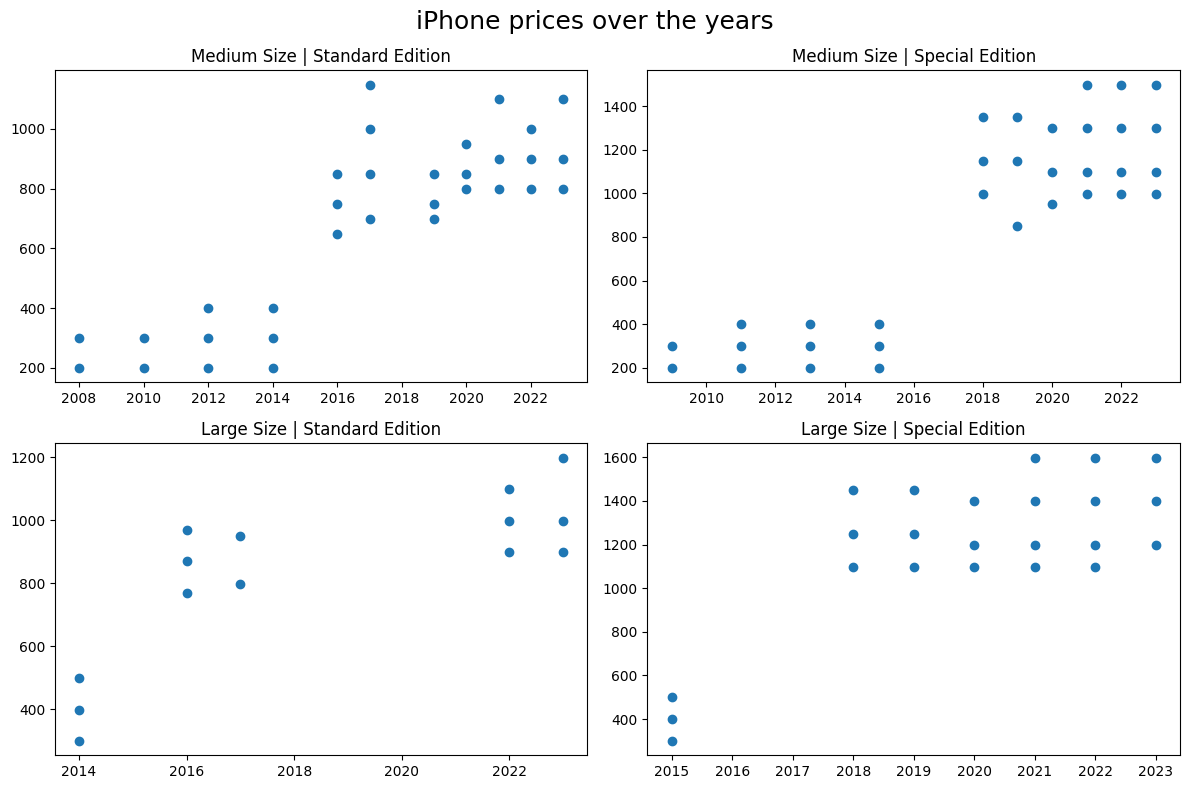

In [263]:
## DATA VISUALIZATION OF PRICES BY CATEGORY 

# PLOT AVERAGE PRICES OF IPHONE EDITIONS OVER THE YEARS 
# DIVIDE INTO CATEGORIES OF SIZE AND EDITION 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8)) 
fig.suptitle("iPhone prices over the years", size=18) 

# plot medium-sized, standard edition iPhones 
axes[0,0].set_title("Medium Size | Standard Edition") 
phones_med_std = iphones.loc[(0 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])] 
axes[0,0].scatter(phones_med_std["YEAR"], phones_med_std["PRICE"])

# plot medium-sized, special edition iPhones 
axes[0,1].set_title("Medium Size | Special Edition") 
phones_med_spec = iphones.loc[(0 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[0,1].scatter(phones_med_spec["YEAR"], phones_med_spec["PRICE"]) 

# plot large-sized, standard edition iPhones 
axes[1,0].set_title("Large Size | Standard Edition") 
phones_lg_std = iphones.loc[(1 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])]
axes[1,0].scatter(phones_lg_std["YEAR"], phones_lg_std["PRICE"])

# plot large-sized, special edition iPhones 
axes[1,1].set_title("Large Size | Special Edition") 
phones_lg_spec = iphones.loc[(1 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[1,1].scatter(phones_lg_spec["YEAR"], phones_lg_spec["PRICE"]) 

fig.tight_layout() 

# WE OBSERVE A SIGNIFICANT PRICE INCREASE IN ALL CATEGORIES BETWEEN 2016 AND 2018 

<Axes: title={'center': 'iPhone storage capacities by year'}, xlabel='YEAR', ylabel='GB'>

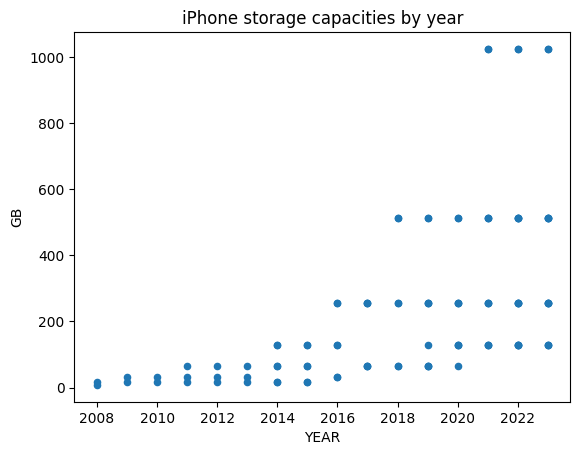

In [264]:
## DATA VISUALIZATION OF STORAGE CAPACITY BY YEAR 

iphones.plot("YEAR", "GB", kind="scatter", title="iPhone storage capacities by year") 

# WE OBSERVE: AS TIME ELAPSES, STORAGE CAPACITIES INCREASE 
# THERE SEEMS TO BE AN EXPONENTIAL (NON-LINEAR) RELATIONSHIP BETWEEN THESE TWO FEATURES 

<Axes: xlabel='GB', ylabel='PRICE'>

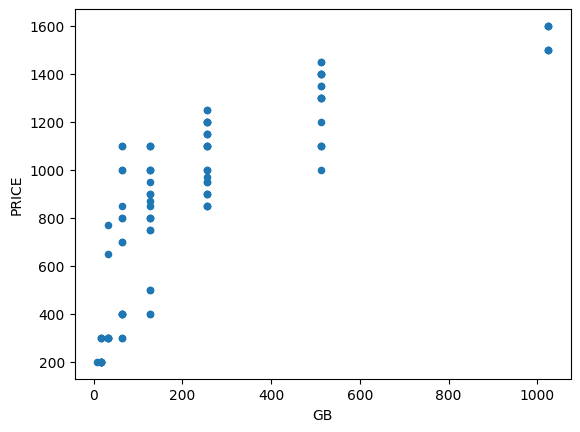

In [265]:
## DATA VISUALIZATION OF PRICES BY STORAGE CAPACITY 
iphones.plot(kind="scatter", x="GB", y="PRICE") 

# WE OBSERVE A POSITIVE CORRELATION BETWEEN STORAGE CAPACITY AND PRICE 
# AS STORAGE CAPACITY INCREASES, SO DOES PRICE

<Axes: xlabel='VERSION', ylabel='PRICE'>

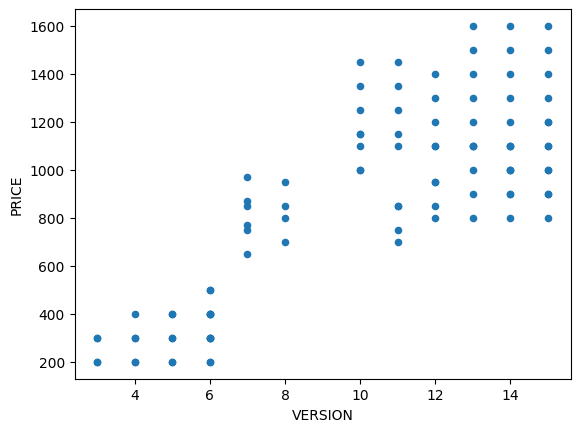

In [266]:
## DATA VISUALIZATION OF PRICES BY VERSION 
iphones.plot(kind="scatter", x="VERSION", y="PRICE") 

# WE OBSERVE: AS VERSION NUMBER INCREASES, SO DOES PRICE 
# POSITIVE CORRELATION

KeyError: 'PRICE_PER_GB'

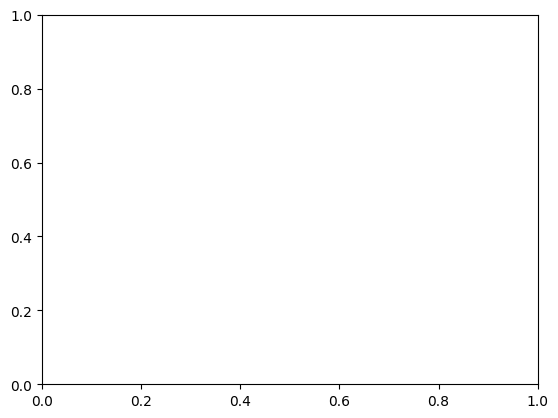

In [272]:
## DATA VISUALIZATION OF PRICE PER GB, BY YEARS 
iphones.plot(kind="scatter", x="YEAR", y="PRICE_PER_GB", title="iPhone prices per GB, by year") 

# WE OBSERVE A (NOISY) DECREASE PRICE_PER_GB OVER TIME 
# AS TIME ELAPSES, STORAGE CAPACITY BECOMES CHEAPER 

<Axes: title={'center': 'iPhone price per GB, by total storage capacity'}, xlabel='GB', ylabel='PRICE_PER_GB'>

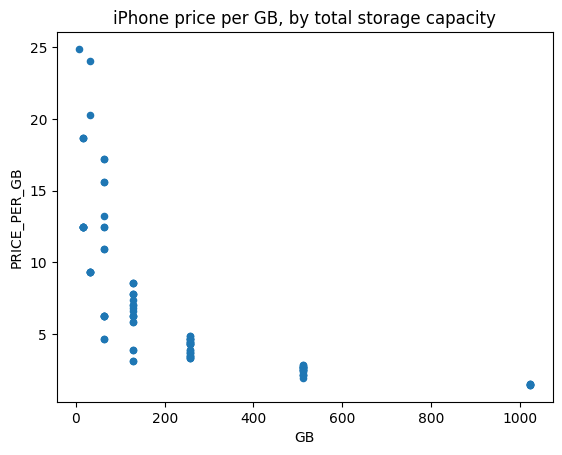

In [268]:
## DATA VISUALIZATION OF PRICE PER GB, BY STORAGE CAPACITY 
iphones.plot(kind="scatter", x="GB", y="PRICE_PER_GB", title="iPhone prices per GB, by total storage capacity") 

# WE OBSERVE A (NON-LINEAR) NEGATIVE CORRELATION BETWEEN PRICE PER GB AND STORAGE CAPACITY 
# AS STORAGE CAPACTY INCREASES, THE PRICE PER GIGABYTE BECOMES A "BETTER DEAL" 

In [269]:
## DROP PRICE_PER_GB COLUMN 
# this was mainly for illustration / analysis 
# since we already have "GB" and "PRICE", this extra column becomes redundant and introduces collinearity into the dataset 

iphones.drop("PRICE_PER_GB", axis=1, inplace=True) 

<Axes: title={'center': 'iPhone versions by year'}, xlabel='YEAR', ylabel='VERSION'>

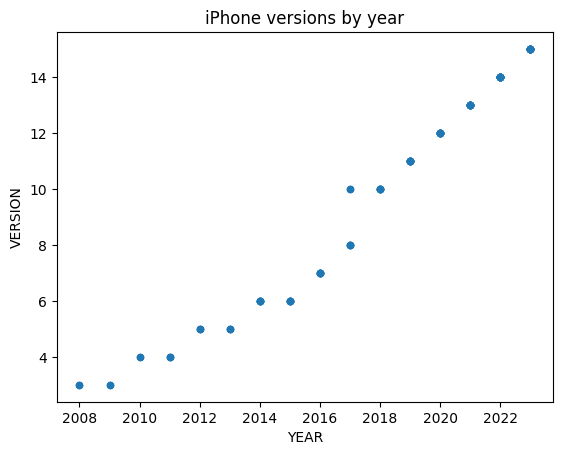

In [270]:
## DATA VISUALIZATION OF YEAR, BY VERSION 
iphones.plot(kind="scatter", x="YEAR", y="VERSION", title="iPhone versions by year") 

# WE OBSERVE HIGH COLLINEARITY BETWEEN "VERSION" AND "YEAR" (OBVIOUSLY) 
# THIS MEANS THAT WE SHOULD NOT USE THEM TOGETHER FOR MODELING / TRAINING 
# "VERSION" WILL BE OMITTED FROM TRAINING, SINCE "YEAR" WILL BE A USER INPUT AND "VERSION" CANNOT BE PREDICTED BY THE USER 

In [271]:
saveOutput(iphones, "iphones_output.csv")

iphones

,YEAR,VERSION,SPECIAL,LARGE,GB,PRICE
2,2008,3,0,0,8,199.0
3,2008,3,0,0,16,299.0
4,2009,3,1,0,16,199.0
5,2009,3,1,0,32,299.0
6,2010,4,0,0,16,199.0
...,...,...,...,...,...,...
109,2023,15,1,0,512,1299.0
110,2023,15,1,0,1024,1499.0
111,2023,15,1,1,256,1199.0
112,2023,15,1,1,512,1399.0
